In [1]:
import numpy as np

import dismech

b = 0.02
h = 0.001

geom = dismech.GeomParams(rod_r0=0.001,
                          shell_h=0,
                          axs=b*h,
                          ixs1=b*h**3/12,
                          ixs2=h*b**3/12,
                          jxs=b*h**3/6)

material = dismech.Material(density=1200,
                            youngs_rod=2e8,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

static_2d_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=True,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=True,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-2,
                                  max_iter=25,
                                  total_time=10.0,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))
env.add_force('floorContact', ground_z=1e-3, stiffness=1e3, delta=2e-3, h=1e-3)
env.add_force('floorFriction', mu=0.25, vel_tol=1e-2)

#geo = dismech.Geometry.from_txt(
#    '../tests/resources/rod_cantilever/horizontal_rod_n51.txt')
geo = dismech.Geometry.from_txt("../input.txt")

robot = dismech.SoftRobot(geom, material, geo, static_2d_sim, env)
stepper = dismech.ImplicitEulerTimeStepper(robot)


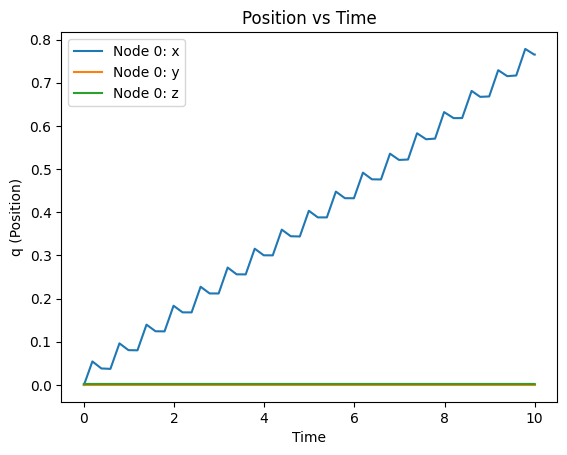

In [2]:
# To avoid duplicate plots
%matplotlib notebook

def actuate_spring(robot: dismech.SoftRobot, t: float):
    """ Simple periodic actuation with mod """
    p1 = 0.2
    p2 = 0.4
    p3 = 0.6
    t_mod = t % p3  # phase in current cycle

    if t_mod < p1:
        robot.stretch_springs.inc_strain[0] -= 3e-2
    elif t_mod < p2:
        robot.stretch_springs.inc_strain[0] += 3e-2
        robot.stretch_springs.inc_strain[1] -= 3e-2
    else: # p3
        robot.stretch_springs.inc_strain[1] += 3e-2

    return robot


stepper.before_step = actuate_spring
viz = dismech.MatplotlibLogger(0)
robots = stepper.simulate(viz = viz)

qs = np.stack([robot.state.q for robot in robots])

In [3]:
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)
options = dismech.AnimationOptions(title='Rod Worm (N=3)', 
                                   y_lim=(-0.1, 0.1), 
                                   z_lim=(1e-3, 10e-3),
                                   camera_view=(10,60))

fig = dismech.get_interactive_animation_plotly(robot, t[::10], qs[::10], options)
fig.show()

In [4]:
import html
ani = dismech.get_animation(robot, t[::10], qs[::10], options)
ani.save('worm.gif')

<IPython.core.display.Javascript object>